#A tutorial introducing PyTorch and an optimiser
In colab, we build torch code that uses autograd and gradient descent optimisers, for toy search problems in 2D.

Marcus Frean

In [1]:
conda uninstall jupyter tornado

Solving environment: done

## Package Plan ##

  environment location: /Users/li/libs/anaconda3

  removed specs:
    - jupyter
    - tornado


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anaconda-client-1.11.0     |   py39hecd8cb5_0         149 KB
    conda-build-3.21.9         |   py39hecd8cb5_0         534 KB
    conda-content-trust-0.1.3  |   py39hecd8cb5_0          71 KB
    conda-package-handling-1.9.0|   py39hca72f7f_0         1.5 MB
    conda-repo-cli-1.0.20      |   py39hecd8cb5_0         108 KB
    conda-token-0.4.0          |     pyhd3eb1b0_0          13 KB
    ffmpeg-4.2.2               |       h97e5cf8_0        22.9 MB
    gmp-6.2.1                  |       he9d5cce_3         525 KB
    libarchive-3.6.1           |       he336d3b_0         718 KB
    libopus-1.3.1              |       h1de35cc_0         480 KB
    libvpx-1.7.0               |       h378b8a2_0         1.3

In [2]:
conda install jupyter

Solving environment: done

## Package Plan ##

  environment location: /Users/li/libs/anaconda3

  added / updated specs:
    - jupyter


The following NEW packages will be INSTALLED:

  anyio              pkgs/main/osx-64::anyio-3.5.0-py39hecd8cb5_0 None
  appnope            pkgs/main/osx-64::appnope-0.1.2-py39hecd8cb5_1001 None
  argon2-cffi        pkgs/main/noarch::argon2-cffi-21.3.0-pyhd3eb1b0_0 None
  argon2-cffi-bindi~ pkgs/main/osx-64::argon2-cffi-bindings-21.2.0-py39hca72f7f_0 None
  asttokens          pkgs/main/noarch::asttokens-2.0.5-pyhd3eb1b0_0 None
  babel              pkgs/main/noarch::babel-2.9.1-pyhd3eb1b0_0 None
  backcall           pkgs/main/noarch::backcall-0.2.0-pyhd3eb1b0_0 None
  bleach             pkgs/main/noarch::bleach-4.1.0-pyhd3eb1b0_0 None
  debugpy            pkgs/main/osx-64::debugpy-1.5.1-py39he9d5cce_0 None
  decorator          pkgs/main/noarch::decorator-5.1.1-pyhd3eb1b0_0 None
  defusedxml         pkgs/main/noarch::defusedxml-0.7.1-pyhd3eb1b0_0 None
 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

Torch gives you Tensors, which are like numpy arrays, but with 
*   **GPU**/CPU choice via *device_type*, and 
*   **AutoGrad** via *requires_grad*




In [59]:
torch.randn(4,5)

tensor([[-2.6582,  0.7238,  0.6904,  0.0565, -0.2346],
        [-0.7464, -0.5095,  1.1449, -1.6259, -1.8797],
        [-0.3875, -0.8288,  0.4686, -1.0061,  0.8751],
        [ 0.2982, -0.7597, -0.5046,  1.5798,  0.5008]])

Here we will make something to minimize....
 
Let's call it "f" -- in practice this is going to be your loss function.

It can be as "interesting" as you like, and can call other functions. 

Here we're going to keep it simple, such as a quadratic bowl, or the Himmelbrau function from the lecture,say.

---

> But JUST FOR EXAMPLE, it could even involve a forward mapping that *uses* these w to map "input vectors" to "outputs", and there could be another function that compares those outputs to some "targets" and gives a scalar, which f could return..... Just saying!
---


In [4]:
def f(w):  
  # Define some interesting surface in a 2-dimensional space.
  # See https://en.wikipedia.org/wiki/Test_functions_for_optimization   for lots of ideas.
  # EXPECTS A TWO-COLUMN TENSOR whose rows are sample vectors,  ie. (x,y) pairs so we can plot them
  #
  x, y = w[:,0], w[:,1]  
  # we're just renaming them x and y to match the notation on that page. 
  
  # Simple Quadratic bowl: 
  #return x*x + y*y   #ALT:  torch.sum(X*X, 1)  or   torch.mul(X,X), 1) or   X.mul(X)
  
  # Himmelblau:
  return torch.pow(x*x + y -11, 2) + torch.pow(x + y*y -7, 2) 
  
  # Bukin6:
  #return 100.0 * torch.sqrt(torch.absolute(y-0.01*x*x)) + 0.01*torch.absolute(x + 10)  
  
  # Easom = brutal! like a golf putting green.
  #return -torch.cos(x) * torch.cos(y) * torch.exp(-((x-np.pi)*(x-np.pi) + (y-np.pi)*(y-np.pi)))
  

In [5]:
w = torch.rand(1,2);
print(w, " --> ",f(w))

tensor([[0.8755, 0.2802]])  -->  tensor([135.6234])


In [6]:
LIMIT = 6.0
NTESTPOINTS = 20
winit = LIMIT * (2*torch.rand(NTESTPOINTS,2)-1) 

In [7]:
w = torch.clone(winit)  
w.requires_grad = True
w.grad

**Question:** why did we have to say `requires_grad` ?

In [8]:
out = f(w)
out.backward( torch.ones_like(out) )
out

tensor([  93.9719, 1290.2473,  595.1162, 1071.9478,    9.3685,  150.1115,
         126.6801,  224.2377,   61.1908,  232.4467,  671.9785,  751.6425,
          78.6583,  282.7883,   67.3813,  227.3974,   98.4991,    7.0440,
           2.2036,  752.5473], grad_fn=<AddBackward0>)

**Question:** what did `out.backward` do?

# try some flavour of Gradient Descent on `f(w)`

At this point we COULD *explicitly* step down the gradient in tiny steps...

But instead, we'll use a torch.optimizer to do it for us.

(note that generic gradient descent is called `SGD` in torch!).

In [9]:
opt = torch.optim.SGD([w], lr=0.01)
opt.step()
w.T

tensor([[ 0.9232, -0.1497,  0.6536,  3.2773, -2.5484, -1.8477, -3.2645,  2.3920,
         -0.9273,  3.3534,  2.2987, -0.1127, -2.9238,  2.2868,  3.1050,  2.3505,
         -2.9630, -2.5431, -2.8230,  3.5642],
        [ 2.0622, -0.9974, -2.3057,  1.7555,  3.0393, -2.5994, -3.3579,  1.7310,
          2.8949, -1.8110, -0.2796,  2.3088,  1.4838,  1.4856, -2.2265,  1.8088,
         -1.4802,  3.1100,  3.1567,  0.5537]], grad_fn=<PermuteBackward0>)

Notice that w has now changed.

That was one step. Let's try several:

In [10]:
STEPS = 20
saved = np.ones((STEPS,len(winit),2))
                 
for t in range(STEPS):
  saved[t,:,:] = w.detach().numpy()
  opt.zero_grad()
  y = f(w)
  y.backward(torch.ones_like(y))
  opt.step()

**Question:** Why did we have to go `w.detach().numpy()` ??

# Now display the trajectories
The code here is a little tedious and you need not pay it much attention - we just want to see those trajectories...

Obviously this sort of display is only possible because we're working in this tiny toy world with only 2 dimensions. 

We use `mgrid` as a handy way to make the coordinates of all the points in a "grid".


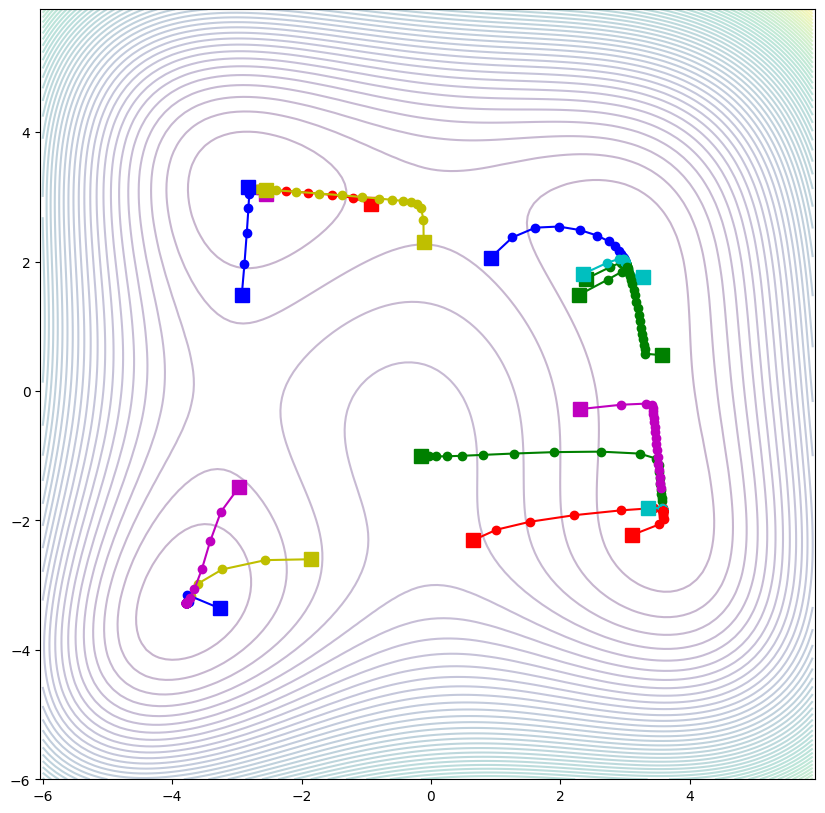

In [11]:
grid = np.mgrid[-LIMIT:LIMIT:0.1,  -LIMIT:LIMIT:0.1]
n, m  = grid.shape[1], grid.shape[2]
xs, ys = grid[0], grid[1]
colors = ['b','g','r','c','m','y']

gridInputs = torch.from_numpy(grid.reshape(2,-1).T)
truesurf = f(gridInputs).numpy()

plt.figure(figsize=(10,10))
plt.contour(xs,ys, truesurf.reshape(n,m), levels=50, alpha=.3)
plt.axis('equal')

for i in range(len(winit)):
  c = colors[i % len(colors)]
  plt.plot(saved[0,i,0],saved[0,i,1],'s',color=c,markersize=10)
  plt.plot(saved[:,i,0],saved[:,i,1],'-',color=c)#'gray')
  plt.plot(saved[:,i,0],saved[:,i,1],'o',color=c)